# Dataset: Baseball Players

In this lab, we will use predictive modeling to design a model that predicts a baseball player’s salary in a given year.

A couple notes about this lab:

Although it isn’t listed as a specific question, don’t forget to clean your data at the beginning. How will you handle missing data? Are there any variables that need adjusting?

There are a lot of variables in the dataset! You may want to use the remainder = "passthrough" trick in your column transformers, rather than typing out a ton of gene names.

Don’t forget that in penalized regression, we must standardize our numeric variables.

There is a lot of repetition in this lab. Think about ways to streamline your code - for example, you might consider writing simple functions to easily create pipelines.

In [23]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
#suppress warnings
warnings.simplefilter("ignore", ConvergenceWarning)
pd.options.mode.chained_assignment = None

In [24]:
hitters = pd.read_csv("/Users/stolieerickson/Documents/MSBA/Fall/GSB544-Computing/Labs/Hitters.csv")

#drop rows with missing values
hitters_clean = hitters.dropna()
hitters_clean.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


## Part I: Different Model Specs

### A. Regression without regularization

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression

2. Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

3. Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [25]:
def fit_tune_regression(X, y, model_type="linear", alpha_values=[0.001, 0.01, 0.1, 1, 10], l1_ratio_values=[0.0, 0.25, 0.5, 0.75, 1.0], cv=5):
    
    #create model pipelines
    if model_type == "linear":
        model = LinearRegression()
        alpha = {}
        l1_ratio = 0
    elif model_type == "ridge":
        model = Ridge()
        alpha = {"regression__alpha": alpha_values}
        l1_ratio = 1
    elif model_type == "lasso":
        model = Lasso()
        alpha = {"regression__alpha": alpha_values}
        l1_ratio = 0
    elif model_type == "elasticnet":
        model = ElasticNet()
        alpha = {"regression__alpha": alpha_values, "regression__l1_ratio": l1_ratio_values}
    else:
        raise ValueError("Unsupported model_type. Choose from 'lasso', 'ridge', 'elasticnet', or 'linear'.")

    #column trnasformer (dummy categorical and standardize numeric)
    ct = ColumnTransformer(
        [("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
         ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))],
        remainder="passthrough"
    )

    pipeline = Pipeline([
        ("preprocessing", ct),
        ("regression", model)
    ])

    #grid search
    grid_search = GridSearchCV(pipeline, alpha, cv=cv, scoring='neg_mean_squared_error')
    grid_search_fitted = grid_search.fit(X, y)

    #find best model
    best_model = grid_search.best_estimator_
    best_model_fitted = best_model.fit(X, y)

    #pull coefficients and variable names
    coefs = best_model.named_steps['regression'].coef_
    feature_names = best_model_fitted.named_steps['preprocessing'].get_feature_names_out()

    #store coefficients in a dataframe
    coefs_df = pd.DataFrame({
        "Feature Name": feature_names,
        "Coefficients": coefs
    })

    #sort coefficients (abs value)
    coefs_df_sorted = coefs_df.reindex(coefs_df['Coefficients'].abs().sort_values(ascending=False).index)

    #print MSE values
    print("Cross-validated MSE scores:", -grid_search_fitted.cv_results_['mean_test_score'])

    #best tuning values
    best_alpha = grid_search.best_params_.get("regression__alpha", None)
    best_l1_ratio = grid_search.best_params_.get("regression__l1_ratio", None)
    best_score = grid_search.best_score_

    #print
    if best_alpha is not None:
        print(f"Best alpha: {best_alpha}")
    if best_l1_ratio is not None:
        print(f"Best l1 ratio: {best_l1_ratio}")
    print(f"Best cross-validated MSE score: {-best_score}")
    
    return coefs_df_sorted


In [26]:
linear_model = fit_tune_regression(hitters_clean.drop(['Salary'], axis = 1), hitters_clean['Salary'], "linear")
linear_model

Cross-validated MSE scores: [121136.31031817]
Best cross-validated MSE score: 121136.31031816891
Cross-validated MSE scores: [121136.31031817]
Best cross-validated MSE score: 121136.31031816891


,Feature Name,Coefficients
16,standardize__CRuns,480.747135
13,standardize__CAtBat,-391.038655
7,standardize__Hits,337.830479
6,standardize__AtBat,-291.094556
17,standardize__CRBI,260.689886
18,standardize__CWalks,-213.892259
11,standardize__Walks,135.073897
14,standardize__CHits,86.687617
19,standardize__PutOuts,78.761296
9,standardize__Runs,-60.572479


Interpretations of top linear variables: ** note: all interpretations assume all else is constant.

1. A higher number of career runs (CRuns) is associated with a higher salary. For each standard unit increase in career runs, predicted salary increases by 480.75 units (in thousands of dollars), making it the most impactful positive predictor in the model.

2. A higher number of career at bats (CAtBat) is associated with a decrease in salary. For each standard unit increase in career at bats, expected salary decreases by 391.04 units. This could suggest that more time at bat, without high success rates, might negatively impact perceived player value.

3. Players in Division E tend to have higher salaries than those in Division W by 58.42 units, suggesting a potential difference in salary norms between divisions.

### B. Ridge regression

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to tune the lambda hyperparameter.

3. Fit the pipeline with your chosen lambda to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [27]:
ridge_model = fit_tune_regression(hitters_clean.drop(['Salary'], axis = 1), hitters_clean['Salary'], "ridge")
ridge_model

Cross-validated MSE scores: [121124.45859213 121022.90328584 120343.62106698 119144.43267692
 119348.9847757 ]
Best alpha: 1
Best cross-validated MSE score: 119144.43267691582
Cross-validated MSE scores: [121124.45859213 121022.90328584 120343.62106698 119144.43267692
 119348.9847757 ]
Best alpha: 1
Best cross-validated MSE score: 119144.43267691582


,Feature Name,Coefficients
16,standardize__CRuns,320.412169
7,standardize__Hits,296.645050
6,standardize__AtBat,-270.686441
13,standardize__CAtBat,-225.406548
18,standardize__CWalks,-184.423611
17,standardize__CRBI,160.386784
14,standardize__CHits,126.659607
11,standardize__Walks,124.407173
19,standardize__PutOuts,78.623656
3,dummify__Division_W,-60.015595


Interpretations of top ridge variables:

1. A higher number of career runs (CRuns) is associated with a higher salary. For each standard unit increase in career runs, predicted salary increases by 320.41 units (in thousands of dollars), making it the most impactful positive predictor in the model.

2. A higher number of hits (Hits) is associated with an increase in salary. For each standard unit increase in hits, expected salary increases by 296.65 units. This suggests that the more successful the batter is at the plate, the higher their salary is.

3. Players in Division E tend to have higher salaries than those in Division W by 60.02 units, suggesting a potential difference in salary norms between divisions.

### C. Lasso Regression

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to tune the lambda hyperparameter.

3. Fit the pipeline with your chosen lambda to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [28]:
lasso_model = fit_tune_regression(hitters_clean.drop(['Salary'], axis = 1), hitters_clean['Salary'], "lasso")
lasso_model

Cross-validated MSE scores: [120994.17981481 120964.76468618 120682.25263745 119761.58740741
 121828.14133339]
Best alpha: 1
Best cross-validated MSE score: 119761.58740741308
Cross-validated MSE scores: [120994.17981481 120964.76468618 120682.25263745 119761.58740741
 121828.14133339]
Best alpha: 1
Best cross-validated MSE score: 119761.58740741308


,Feature Name,Coefficients
16,standardize__CRuns,3.755655e+02
7,standardize__Hits,3.043595e+02
6,standardize__AtBat,-2.823710e+02
17,standardize__CRBI,1.926109e+02
18,standardize__CWalks,-1.896446e+02
13,standardize__CAtBat,-1.626398e+02
11,standardize__Walks,1.206953e+02
2,dummify__Division_E,1.144130e+02
19,standardize__PutOuts,7.876037e+01
20,standardize__Assists,4.199668e+01


Interpretations of top lasso variables:

1. A higher number of career runs (CRuns) is associated with a higher salary. For each standard unit increase in career runs, predicted salary increases by 375.57 units (in thousands of dollars), making it the most impactful positive predictor in the model.

2. A higher number of hits (Hits) is associated with an increase in salary. For each standard unit increase in hits, expected salary increases by 304.36 units. This suggests that the more successful the batter is at the plate, the higher their salary is.

3. Players in Division E tend to have higher salaries than those in Division W by 114.42 units, suggesting a potential difference in salary norms between divisions.

### D. Elastic Net

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to tune the lambda and alpha hyperparameters.

3. Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [29]:
elastic_model = fit_tune_regression(hitters_clean.drop(['Salary'], axis = 1), hitters_clean['Salary'], "elasticnet")
elastic_model

Cross-validated MSE scores: [119911.32888951 120077.76864311 120296.21077347 120590.44872106
 120994.17981481 118957.96789175 119009.79955442 119123.79308625
 119404.65600998 120964.76468618 119805.47261377 119636.17022676
 119381.37557129 119036.41354271 120682.25263745 122029.76100625
 121374.33374621 120775.68540067 120356.59599777 119761.58740741
 150034.24612426 144021.73108229 136766.42534889 128407.50504979
 121828.14133339]
Best alpha: 0.01
Best l1 ratio: 0.0
Best cross-validated MSE score: 118957.96789174958
Cross-validated MSE scores: [119911.32888951 120077.76864311 120296.21077347 120590.44872106
 120994.17981481 118957.96789175 119009.79955442 119123.79308625
 119404.65600998 120964.76468618 119805.47261377 119636.17022676
 119381.37557129 119036.41354271 120682.25263745 122029.76100625
 121374.33374621 120775.68540067 120356.59599777 119761.58740741
 150034.24612426 144021.73108229 136766.42534889 128407.50504979
 121828.14133339]
Best alpha: 0.01
Best l1 ratio: 0.0
Best 

,Feature Name,Coefficients
7,standardize__Hits,249.932752
6,standardize__AtBat,-233.288530
16,standardize__CRuns,226.828966
18,standardize__CWalks,-156.494373
14,standardize__CHits,123.652433
17,standardize__CRBI,122.933345
13,standardize__CAtBat,-122.140608
11,standardize__Walks,111.867856
19,standardize__PutOuts,77.975918
2,dummify__Division_E,60.813166


Interpretations of top elastic net variables:

1. A higher number of hits (Hits) is associated with a higher salary. For each standard unit increase in career runs, predicted salary increases by 249.93 units (in thousands of dollars), making it the most impactful positive predictor in the model.

2. A higher number of at bats (AtBat) is associated with a decrease in salary. For each standard unit increase in career at bats, expected salary decreases by 233.29 units.

3. Players in Division E tend to have higher salaries than those in Division W by 60.81 units, suggesting a potential difference in salary norms between divisions.

## Part II. Variable Selection

Based on the above results, decide on:

- Which numeric variable is most important.
- Which five numeric variables are most important
- Which categorical variable is most important

For each of the four model specifications, compare the following possible feature sets:

- Using only the one best numeric variable.
- Using only the five best variables.
- Using the five best numeric variables and their interactions with the one best categorical variable.

Report which combination of features and model performed best, based on the validation metric of MSE.
(Note: lambda and alpha must be re-tuned for each feature set.)

### Linear Regression

In [30]:
#printing the top 5
print(linear_model.head())
print(ridge_model.head())
print(lasso_model.head())
print(elastic_model.head())

           Feature Name  Coefficients
16   standardize__CRuns    480.747135
13  standardize__CAtBat   -391.038655
7     standardize__Hits    337.830479
6    standardize__AtBat   -291.094556
17    standardize__CRBI    260.689886
           Feature Name  Coefficients
16   standardize__CRuns    320.412169
7     standardize__Hits    296.645050
6    standardize__AtBat   -270.686441
13  standardize__CAtBat   -225.406548
18  standardize__CWalks   -184.423611
           Feature Name  Coefficients
16   standardize__CRuns    375.565519
7     standardize__Hits    304.359509
6    standardize__AtBat   -282.370957
17    standardize__CRBI    192.610892
18  standardize__CWalks   -189.644642
           Feature Name  Coefficients
7     standardize__Hits    249.932752
6    standardize__AtBat   -233.288530
16   standardize__CRuns    226.828966
18  standardize__CWalks   -156.494373
14   standardize__CHits    123.652433
           Feature Name  Coefficients
16   standardize__CRuns    480.747135
13  standard

The top numeric variable is CRuns

The top 5 numeric variables are:

    1. CRuns

    2. Hits

    3. AtBat

    4. CAtBat

    5. CWalks
    
The top categorical variable is Division

In [44]:
#using only the best numeric variable
fit_tune_regression(hitters_clean[["CRuns"]], hitters_clean['Salary'], "linear")

Cross-validated MSE scores: [143812.9359163]
Best cross-validated MSE score: 143812.9359162973
Cross-validated MSE scores: [143812.9359163]
Best cross-validated MSE score: 143812.9359162973


,Feature Name,Coefficients
0,standardize__CRuns,253.351392


In [45]:
#top 5 numeric variables
top5 = ["CRuns", "Hits", "AtBat", "CAtBat", "CWalks"]
#using the top 5 numeric variables, no interaction
fit_tune_regression(hitters_clean[top5], hitters_clean['Salary'], "linear")

Cross-validated MSE scores: [127649.37020398]
Best cross-validated MSE score: 127649.37020397605
Cross-validated MSE scores: [127649.37020398]
Best cross-validated MSE score: 127649.37020397605


,Feature Name,Coefficients
0,standardize__CRuns,456.319655
1,standardize__Hits,327.135303
3,standardize__CAtBat,-234.721048
2,standardize__AtBat,-196.706159
4,standardize__CWalks,-4.068062


In [33]:
#create dummy variables for division
division_dummies = pd.get_dummies(hitters_clean['Division'], prefix='Division', drop_first=True)
hitters_clean = pd.concat([hitters_clean, division_dummies], axis=1)

#function to make interaction columns
def create_interaction(df, quantvars, catvar):
    for quantvar in quantvars:
        #interaction column for each quantitative variable
        df[f"{quantvar}_x_{catvar}"] = df[quantvar] * df[catvar]
    return df

#call the function
hitters_clean = create_interaction(hitters_clean, top5, 'Division_W')

#make sure it worked
hitters_clean.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,Division_W,CRuns_x_Division_W,Hits_x_Division_W,AtBat_x_Division_W,CAtBat_x_Division_W,CWalks_x_Division_W
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N,True,321,81,315,3449,375
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A,True,224,130,479,1624,263
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N,False,0,0,0,0,0
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N,False,0,0,0,0,0
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A,True,501,169,594,4408,194


In [46]:
#pull interaction columns
interaction_columns = hitters_clean.filter(regex='_x_').columns.tolist()

#combine all predictors
selected_columns = top5 + interaction_columns + ['Division_W']

#fit regression
fit_tune_regression(hitters_clean[selected_columns], hitters_clean['Salary'], "linear")

Cross-validated MSE scores: [132104.0877176]
Best cross-validated MSE score: 132104.08771759563
Cross-validated MSE scores: [132104.0877176]
Best cross-validated MSE score: 132104.08771759563


,Feature Name,Coefficients
0,standardize__CRuns,577.187656
7,standardize__AtBat_x_Division_W,515.649819
6,standardize__Hits_x_Division_W,-478.862753
1,standardize__Hits,447.404648
8,standardize__CAtBat_x_Division_W,355.962321
5,standardize__CRuns_x_Division_W,-348.935166
3,standardize__CAtBat,-324.790653
2,standardize__AtBat,-324.539068
10,remainder__Division_W,-126.232645
9,standardize__CWalks_x_Division_W,-73.337121


### Ridge Regression

In [47]:
#using only the best numeric variable
fit_tune_regression(hitters_clean[["CRuns"]], hitters_clean['Salary'], "ridge")

Cross-validated MSE scores: [143812.90501458 143812.62705116 143809.86245611 143783.70685419
 143658.51736859]
Best alpha: 10
Best cross-validated MSE score: 143658.5173685888
Cross-validated MSE scores: [143812.90501458 143812.62705116 143809.86245611 143783.70685419
 143658.51736859]
Best alpha: 10
Best cross-validated MSE score: 143658.5173685888


,Feature Name,Coefficients
0,standardize__CRuns,244.071121


In [48]:
#using the top 5 numeric variables, no interaction
fit_tune_regression(hitters_clean[top5], hitters_clean['Salary'], "ridge")

Cross-validated MSE scores: [127647.79274475 127633.69370585 127501.96337709 126800.37050367
 128037.29050591]
Best alpha: 1
Best cross-validated MSE score: 126800.37050367217
Cross-validated MSE scores: [127647.79274475 127633.69370585 127501.96337709 126800.37050367
 128037.29050591]
Best alpha: 1
Best cross-validated MSE score: 126800.37050367217


,Feature Name,Coefficients
0,standardize__CRuns,380.505983
1,standardize__Hits,307.149947
2,standardize__AtBat,-173.562058
3,standardize__CAtBat,-171.164182
4,standardize__CWalks,7.992500


In [49]:
#using the top 5 numeric variables, with interaction
fit_tune_regression(hitters_clean[selected_columns], hitters_clean['Salary'], "ridge")

Cross-validated MSE scores: [132097.27417543 132037.4725731  131560.31605707 129960.49843623
 126904.65728349]
Best alpha: 10
Best cross-validated MSE score: 126904.65728349378
Cross-validated MSE scores: [132097.27417543 132037.4725731  131560.31605707 129960.49843623
 126904.65728349]
Best alpha: 10
Best cross-validated MSE score: 126904.65728349378


,Feature Name,Coefficients
1,standardize__Hits,186.913169
0,standardize__CRuns,184.772545
9,standardize__CWalks_x_Division_W,-70.216161
4,standardize__CWalks,48.603938
2,standardize__AtBat,-47.255382
6,standardize__Hits_x_Division_W,-34.827895
3,standardize__CAtBat,29.468486
10,remainder__Division_W,14.445102
5,standardize__CRuns_x_Division_W,-10.609747
7,standardize__AtBat_x_Division_W,3.519728


### Lasso Regression

In [50]:
#using only the best numeric variable
fit_tune_regression(hitters_clean[["CRuns"]], hitters_clean['Salary'], "lasso")

Cross-validated MSE scores: [143812.92354516 143812.8122987  143811.70912151 143801.60608406
 143793.44915854]
Best alpha: 10
Best cross-validated MSE score: 143793.4491585397
Cross-validated MSE scores: [143812.92354516 143812.8122987  143811.70912151 143801.60608406
 143793.44915854]
Best alpha: 10
Best cross-validated MSE score: 143793.4491585397


,Feature Name,Coefficients
0,standardize__CRuns,243.351392


In [51]:
#using the top 5 numeric variables, no interaction
fit_tune_regression(hitters_clean[top5], hitters_clean['Salary'], "lasso")

Cross-validated MSE scores: [127648.6718963  127642.40905698 127581.89096439 127187.74346482
 128429.54257044]
Best alpha: 1
Best cross-validated MSE score: 127187.74346481934
Cross-validated MSE scores: [127648.6718963  127642.40905698 127581.89096439 127187.74346482
 128429.54257044]
Best alpha: 1
Best cross-validated MSE score: 127187.74346481934


,Feature Name,Coefficients
0,standardize__CRuns,392.706162
1,standardize__Hits,302.974589
3,standardize__CAtBat,-175.400706
2,standardize__AtBat,-170.154812
4,standardize__CWalks,0.000000


In [52]:
#using the top 5 numeric variables, with interaction
fit_tune_regression(hitters_clean[selected_columns], hitters_clean['Salary'], "lasso")

Cross-validated MSE scores: [132092.43131067 132053.81808984 131692.0730298  130266.41712657
 125801.75705113]
Best alpha: 10
Best cross-validated MSE score: 125801.75705113329
Cross-validated MSE scores: [132092.43131067 132053.81808984 131692.0730298  130266.41712657
 125801.75705113]
Best alpha: 10
Best cross-validated MSE score: 125801.75705113329


,Feature Name,Coefficients
0,standardize__CRuns,246.924957
1,standardize__Hits,133.933901
9,standardize__CWalks_x_Division_W,-53.996084
6,standardize__Hits_x_Division_W,-25.845140
5,standardize__CRuns_x_Division_W,-7.955686
2,standardize__AtBat,-0.000000
3,standardize__CAtBat,0.000000
4,standardize__CWalks,0.000000
7,standardize__AtBat_x_Division_W,-0.000000
8,standardize__CAtBat_x_Division_W,-0.000000


### Elastic Net Regression

In [53]:
#using only the best numeric variable
fit_tune_regression(hitters_clean[["CRuns"]], hitters_clean['Salary'], "elasticnet")

Cross-validated MSE scores: [143806.42455599 143808.03538837 143809.65548849 143811.28486965
 143812.92354516 143754.43301037 143767.67766747 143781.81382835
 143796.85435465 143812.8122987  143779.6466328  143687.04556094
 143655.07604767 143693.04973161 143811.70912151 157624.93859252
 153588.16652086 149274.99427665 145289.39892935 143801.60608406
 194371.29302845 191404.80929793 186199.04562055 174810.69127625
 143793.44915854]
Best alpha: 0.1
Best l1 ratio: 0.5
Best cross-validated MSE score: 143655.07604766646
Cross-validated MSE scores: [143806.42455599 143808.03538837 143809.65548849 143811.28486965
 143812.92354516 143754.43301037 143767.67766747 143781.81382835
 143796.85435465 143812.8122987  143779.6466328  143687.04556094
 143655.07604767 143693.04973161 143811.70912151 157624.93859252
 153588.16652086 149274.99427665 145289.39892935 143801.60608406
 194371.29302845 191404.80929793 186199.04562055 174810.69127625
 143793.44915854]
Best alpha: 0.1
Best l1 ratio: 0.5
Best cr

,Feature Name,Coefficients
0,standardize__CRuns,241.239421


In [54]:
#using the top 5 numeric variables, no interaction
fit_tune_regression(hitters_clean[top5], hitters_clean['Salary'], "elasticnet")

Cross-validated MSE scores: [127360.04171882 127424.54605246 127493.90004866 127568.47377713
 127648.6718963  126648.16974756 126666.32832458 126777.95501404
 127054.75757972 127642.40905698 129188.85111023 128763.12468917
 128125.37185885 127185.16006204 127581.89096439 133972.18712472
 132539.73901984 131336.03247014 130321.54180695 127187.74346482
 173478.53036719 167536.72761967 158847.18764031 145552.28888459
 128429.54257044]
Best alpha: 0.01
Best l1 ratio: 0.0
Best cross-validated MSE score: 126648.16974756433
Cross-validated MSE scores: [127360.04171882 127424.54605246 127493.90004866 127568.47377713
 127648.6718963  126648.16974756 126666.32832458 126777.95501404
 127054.75757972 127642.40905698 129188.85111023 128763.12468917
 128125.37185885 127185.16006204 127581.89096439 133972.18712472
 132539.73901984 131336.03247014 130321.54180695 127187.74346482
 173478.53036719 167536.72761967 158847.18764031 145552.28888459
 128429.54257044]
Best alpha: 0.01
Best l1 ratio: 0.0
Best 

,Feature Name,Coefficients
0,standardize__CRuns,306.987777
1,standardize__Hits,279.084629
2,standardize__AtBat,-142.605113
3,standardize__CAtBat,-109.404969
4,standardize__CWalks,19.375450


In [55]:
#using the top 5 numeric variables, with interaction
fit_tune_regression(hitters_clean[selected_columns], hitters_clean['Salary'], "elasticnet")

Cross-validated MSE scores: [131167.69449883 131333.69197421 131533.68879692 131780.42267733
 132092.43131067 129038.09674714 129427.71253889 129900.37651437
 130520.02194203 132053.81808984 126336.39170288 126508.47682515
 126839.16352286 127607.82441985 131692.0730298  130480.59587837
 128617.41337655 127055.69941256 126121.26682062 130266.41712657
 172913.32115171 167000.36165471 158195.09591034 144020.58107469
 125801.75705113]
Best alpha: 10
Best l1 ratio: 1.0
Best cross-validated MSE score: 125801.75705113329
Cross-validated MSE scores: [131167.69449883 131333.69197421 131533.68879692 131780.42267733
 132092.43131067 129038.09674714 129427.71253889 129900.37651437
 130520.02194203 132053.81808984 126336.39170288 126508.47682515
 126839.16352286 127607.82441985 131692.0730298  130480.59587837
 128617.41337655 127055.69941256 126121.26682062 130266.41712657
 172913.32115171 167000.36165471 158195.09591034 144020.58107469
 125801.75705113]
Best alpha: 10
Best l1 ratio: 1.0
Best cros

,Feature Name,Coefficients
0,standardize__CRuns,246.924957
1,standardize__Hits,133.933901
9,standardize__CWalks_x_Division_W,-53.996084
6,standardize__Hits_x_Division_W,-25.845140
5,standardize__CRuns_x_Division_W,-7.955686
2,standardize__AtBat,-0.000000
3,standardize__CAtBat,0.000000
4,standardize__CWalks,0.000000
7,standardize__AtBat_x_Division_W,-0.000000
8,standardize__CAtBat_x_Division_W,-0.000000


The best model was the elastic net with interactions model.

## Part III. Discussion

### A. Ridge

Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

The coefficients in the ordinary regression are larger than that of the ridge regression. This makes sense because ridge regression minimizes both the residual sum of squares and the squared sum of coefficients. Ridge regression reduces overfitting by controlling large coefficient values and finds a balance between bias and variance.


### B. LASSO

Compare your LASSO model in I with your three LASSO models in II. Did you get the same lambda results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

The Lasso model in I generated a lambda of 1 and a cross-validated MSE of 119761.59. The Lasso models in II generated lambdas of 10, 1, and 10, with MSEs of 143793.45, 127187.74, and 125801.76 respectively. 

The differences in lambda values across the Lasso models reflect the complexity of the feature sets. For Model I (all variables), lambda is set to 1, balancing regularization and feature selection. In Model II (top variable), lambda increases to 10 due to the simplicity of using only one predictor, requiring stronger regularization to prevent overfitting. Model III (top 5 variables) maintains a moderate lambda of 1, as the model is more complex but still manageable with standard regularization. Model IV (top 5 variables with interactions) sees lambda rise to 10, reflecting the added complexity of interaction terms, which necessitate stronger penalization to maintain model stability.

The MSE values highlight how model complexity impacts prediction accuracy. Model I, which includes all variables, achieves the lowest MSE (119,761.59) because it leverages a larger set of features to capture more variance in the data. However, as complexity increases in Model II (top variable), the MSE rises to 143,793.45, indicating that a single feature lacks the predictive power needed for accurate forecasting. Models III and IV, with top 5 features and interactions, show moderate MSEs, as they strike a balance between complexity and predictive power, but the inclusion of interactions in Model IV leads to a slightly lower MSE.

### C. Elastic Net

Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

MSEs for Ridge, Lasso and Elastic Net(Part I): 119144.43, 119761.59, 118957.97

Elastic Net tends to "win" because it combines the strengths of both Ridge and Lasso regularization, balancing between L1 and L2 penalties. This allows it to handle both correlated predictors and sparse models more effectively, as seen in its consistently lower MSE compared to Ridge and Lasso. By leveraging both regularization methods, Elastic Net can often outperform the others in complex data scenarios, as demonstrated by its better MSE scores in both Part I (where all models use the same predictors).

## Part IV: Final Model

Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

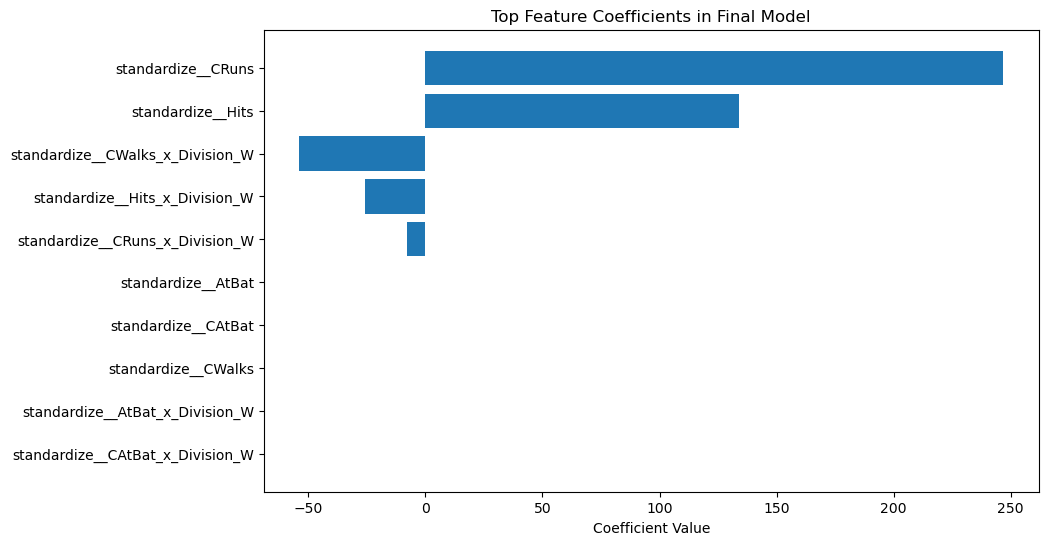

,Feature Name,Coefficients
0,standardize__CRuns,246.924957
1,standardize__Hits,133.933901
9,standardize__CWalks_x_Division_W,-53.996084
6,standardize__Hits_x_Division_W,-25.845140
5,standardize__CRuns_x_Division_W,-7.955686
2,standardize__AtBat,-0.000000
3,standardize__CAtBat,0.000000
4,standardize__CWalks,0.000000
7,standardize__AtBat_x_Division_W,-0.000000
8,standardize__CAtBat_x_Division_W,-0.000000


In [61]:
#set best parameters from above
alpha = 10 
l1_ratio = 1.0

model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

#dummify and standardize
ct = ColumnTransformer([
    ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
], remainder="passthrough")

#pipeline for preprocession and regression creation
pipeline = Pipeline([
    ("preprocessing", ct),
    ("regression", model)
])

#fit to entire dataset
pipeline.fit(hitters_clean[selected_columns], hitters_clean['Salary'])

#pull coefficients
coefs = pipeline.named_steps['regression'].coef_

#pull feature names (columns)
feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()

#store in a df
coefs_df = pd.DataFrame({
    "Feature Name": feature_names,
    "Coefficients": coefs
})
coefs_df_sorted = coefs_df.reindex(coefs_df['Coefficients'].abs().sort_values(ascending=False).index)

#plot
plt.figure(figsize=(10, 6))
plt.barh(coefs_df_sorted['Feature Name'][:10], coefs_df_sorted['Coefficients'][:10])
plt.xlabel("Coefficient Value")
plt.title("Top Feature Coefficients in Final Model")
plt.gca().invert_yaxis()
plt.show()

#show coefficients
coefs_df_sorted


The plot of the top coefficients in the model reveals the most influential features affecting player salaries, with CRuns (career runs) and Hits standing out with positive coefficients, indicating a strong positive relationship with salary. Conversely, features such as CWalks_x_Division_W (career walks when in Division W) and Hits_x_Division_W have negative coefficients, showing a reduction in salary for players with these attributes in this division.

Notably, several coefficients are zero, including AtBat, CAtBat, and several interaction terms like AtBat_x_Division_W. This zeroing of coefficients is due to the ElasticNet model’s regularization, which combines the effects of both L1 (lasso) and L2 (ridge) penalties. L1 regularization in particular promotes sparsity by pushing less influential features' coefficients to zero, simplifying the model by retaining only the most impactful variables.

## References and Appendix

- https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.cross_val_score.html
- https://matplotlib.org/stable/tutorials/pyplot.html
- https://machinelearningmastery.com/lasso-regression-with-python/
- https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.ElasticNet.html
- https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.Ridge.html

AI Statement:

Throughout the lab, I primarily used AI assistance to troubleshoot and resolve errors. I consulted it for refining my function creation in Part 1, helping to clarify the structure and streamline my code. In Part 5, I used AI to brainstorm effective plotting ideas, ensuring I could best represent the results visually. Overall, AI was a valuable tool for guidance on specific technical issues while allowing me to work through the lab’s core tasks independently.